# Bonus 1: Numerical Optimization for Logistic Regression.

### Name: Sarita Hedaya


1. Read the lecture note [click here (Links to an external site.)]  and the corresponding research papers.

 

2. Implement federated averaging (easier) and/or decentralized optimization (harder). 2 bonus points for each. If you do both, submit them as two separate IPYNB files.

 

3. Data: use the data and template of Bonus 1.

 

4. Requirement for federated averaging:







*   Use 4 worker nodes.
*   Use GD and SGD (with batch size b=1).
* Set the number of local iterations to q=1 and 8.
* Plot (training) objective function against epochs. Note that one epoch means every sample is visited exactly once.
* Note also that there are 4 lines in your plot. (GD with q=1, GD with q=8, SGD with q=1, SGD with q=8.)


 



 

5. Requirement for decentralized optimization:

* Use 7 worker nodes; the connection must be the same as the figure in the lecture note.
* Use GD.
* Try weighted averaging (give a worker's own parameter a higher weight than its neighbors' parameters) and simple averaging (everyone has the same weight).
* Plot (training) objective function against epochs. 
* Note that there are at least 2 lines in your plot. (Corresponding to the weighting schemes.)
 

# 1. Data processing

- Download the Diabete dataset from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
- Load the data using sklearn.
- Preprocess the data.

## 1.1. Load the data

In [122]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [123]:
from sklearn import datasets
import numpy

x_sparse, y = datasets.load_svmlight_file('/content/drive/My Drive/F19/CS 583 - Deep Learning/diabetes.txt')
x = x_sparse.todense()

print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x: (768, 8)
Shape of y: (768,)


## 1.2. Partition to training and test sets

In [124]:
# partition the data to training and test sets
n = x.shape[0]
n_train = int(numpy.ceil(n * 0.8))
n_test = n - n_train

rand_indices = numpy.random.permutation(n)
train_indices = rand_indices[0:n_train]
test_indices = rand_indices[n_train:n]

x_train = x[train_indices, :]
x_test = x[test_indices, :]
y_train = y[train_indices].reshape(n_train, 1)
y_test = y[test_indices].reshape(n_test, 1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (615, 8)
Shape of x_test: (153, 8)
Shape of y_train: (615, 1)
Shape of y_test: (153, 1)


## 1.3. Feature scaling

Use the standardization to trainsform both training and test features

In [125]:
# Standardization
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))

test mean = 
[[-0.02772253 -0.01282227 -0.03617019 -0.12011721 -0.13112678  0.05843218
  -0.00777865  0.0348263 ]]
test std = 
[[1.06239624 1.03295418 1.20271906 1.0481506  0.80986955 1.13534821
  1.1623515  1.09814328]]


## 1.4. Add a dimension of all ones

In [126]:
n_train, d = x_train.shape
x_train = numpy.concatenate((x_train, numpy.ones((n_train, 1))), axis=1)

n_test, d = x_test.shape
x_test = numpy.concatenate((x_test, numpy.ones((n_test, 1))), axis=1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

Shape of x_train: (615, 9)
Shape of x_test: (153, 9)


# 2. Define class Worker and Server

## 2.1 Worker Class definition

In [0]:
class Worker:
    def __init__(self, x, y, batch_size=None):
        self.x = x # s−by−d local feature matrix
        self.y = y # s-by-1 local labels matrix
        self.s = x.shape[0] # number of local samples
        self.d = x.shape[1] # number of features
        self.w = numpy.zeros((d, 1)) # d-by-1 model parameter vector

    def set_param(self, w):
        self.w = w

    def loss(self):
        """ Computes the local loss """
        yx = numpy.multiply(self.y, self.x) # s−by−d matrix
        yxw = numpy.dot(yx, self.w) # s-by-1 matrix
        vec1 = numpy.exp(-yxw) #s-by-1 matrix
        vec2 = numpy.log(1 + vec1) # s-by-1 matrix
        return numpy.sum(vec2)

    def gradient(self):
        """ Computes the local gradient """
        yx = numpy.multiply(self.y, self.x) # s−by−d matrix
        yxw = numpy.dot(yx, self.w) # s-by-1 matrix
        vec1 = numpy.exp(yxw) #s-by-1 matrix
        vec2 = numpy.divide(yx, 1 + vec1) # s-by-d 
        g = -numpy.sum(vec2, axis=0).reshape(self.d, 1) # d-by-1
        return g

## 2.2 Server Class definition

In [0]:
class Server:
  def __init__(self, m, n, d):
    self.m = m
    self.n = n
    self.d = d
    self.w = numpy.zeros((d, 1))
    self.g = numpy.zeros((d, 1))
    self.v = numpy.zeros((d, 1))
    self.loss = 0
    self.obj = 0
    
  def broadcast(self):
    return self.w
  
  def aggregate(self, grads, losses):
    """ Sum the gradients and loss functions evaluated by the workers
    Args: 
      grads: a list of d-by-1 vectors
      losses: a list of scalars
    """
    self.g = numpy.zeros((self.d, 1))
    self.loss = 0
    for k in range(self.m):
      self.g += grads[k]
      self.loss += losses[k]
      
  def gradient(self, lam):
    """ Compute the gradient from loss and regularization """
    self.g = self.g / self.n + lam * self.w
    
  def objective(self, lam):
    """ Compute objective function = sum of loss and regularization """
    reg = lam / 2 * numpy.sum(self.w * self.w)
    self.obj = self.loss / self.n + reg
    return self.obj
  
  
  def agd(self, alpha, beta):
    """ Update the model paramteters using accelerated gradient descent.
    Args:
      alpha: learning rate
      beta: momentum parameter
    """
    self.v *= beta
    self.v += self.g
    self.w -= alpha * self.v

## 2.3 Initialization

In [0]:
import math

def create_server_workers(m, x, y):
  n, d = x.shape
  s = math.floor(n / m)
  server = Server(m, n, d)
  workers = []
  
  for i in range(m):
    indeces = list(range(i*s, (i + 1)*s))
    worker = Worker(x[indeces, :], y[indeces, :])
    workers.append(worker)
    
  return server, workers

In [0]:
m = 4
server, workers = create_server_workers(4, x_train, y_train)

### Gradient Descent parallel computation

In [139]:
lam = 1E-6
alpha = 1E-1
beta=0.9
max_epoch=50


objvals_gd = []

for t in range(max_epoch):
    # step1: broadcast
    w = server.broadcast()
    for i in range(m):
        workers[i].set_param(w)

    # step2: perform worker's local computations
    grads=[]
    losses=[]
    for i in range(m):
        g = workers[i].gradient()
        grads.append(g)

        l = workers[i].loss()
        losses.append(l)

    # step3: aggregate worker's output
    server.aggregate(grads, losses)

    # step4: server update the model params
    server.gradient(lam)
    obj = server.objective(lam)
    print("objective function value at ", str(t+1), " = ", str(obj))
    objvals_gd.append(obj)
    server.agd(alpha, beta)

objective function value at  1  =  0.6897659748011163
objective function value at  2  =  0.677537867443514
objective function value at  3  =  0.6561695347979073
objective function value at  4  =  0.6296167442517455
objective function value at  5  =  0.601761942067588
objective function value at  6  =  0.5756481277630227
objective function value at  7  =  0.5531106713357387
objective function value at  8  =  0.5348435258500475
objective function value at  9  =  0.5207251092734227
objective function value at  10  =  0.5101872560673841
objective function value at  11  =  0.5025018371485238
objective function value at  12  =  0.4969567083019826
objective function value at  13  =  0.4929418739258109
objective function value at  14  =  0.48997777045224555
objective function value at  15  =  0.4877118998911982
objective function value at  16  =  0.48590097558950346
objective function value at  17  =  0.4843883651346669
objective function value at  18  =  0.48308182379749254
objective function

### SGD with parallel computation

Helper code first

In [0]:
# Calculate the objective Q_i and the gradient of Q_i
# Inputs:
#     w: d-by-1 matrix
#     xi: 1-by-d matrix
#     yi: scalar
#     lam: scalar, the regularization parameter
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i
def stochastic_objective_gradient(w, xi, yi, lam):
    d = xi.shape[0]
    yx = yi * xi # 1-by-d matrix
    yxw = float(numpy.dot(yx, w)) # scalar
    
    # calculate objective function Q_i
    loss = numpy.log(1 + numpy.exp(-yxw)) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    obj = loss + reg
    
    # calculate stochastic gradient
    g_loss = -yx.T / (1 + numpy.exp(yxw)) # d-by-1 matrix
    g = g_loss + lam * w # d-by-1 matrix
    
    return obj, g

In [0]:
lam = 1E-6
alpha = 1E-1
beta=0.9
max_epoch=50


objvals_gd = []

for t in range(max_epoch):
    # step1: broadcast
    w = server.broadcast()
    for i in range(m):
        workers[i].set_param(w)

    # step2: perform worker's local computations
    grads=[]
    losses=[]
    for i in range(m):
        for sample_id in range(len(workers[i].x)):
            obj, g = stochastic_objective_gradient(workers[i].w, workers[i].x[sample_id], workers[i].y[sample_id], lam)


    # step3: aggregate worker's output
    server.aggregate(grads, losses)

    # step4: server update the model params
    server.gradient(lam)
    obj = server.objective(lam)
    print("objective function value at ", str(t+1), " = ", str(obj))
    objvals_gd.append(obj)
    server.agd(alpha, beta)

### Gradient descent Federated Average

In [141]:
lam = 1E-6
alpha = 1E-1
beta=0.9
max_epoch=50
local_iters = 8

objvals_gd_q8 = []



for t in range(int(max_epoch/local_iters)):
    # step1: broadcast
    w = server.broadcast()
    for i in range(m):
        workers[i].set_param(w)

    # step2: perform worker's local computations
    grads = []
    losses = []
    # print(grads)
    # print(losses)        

    # g_per_iter.average(axis=1)

    for i in range(m):
        worker_grads = numpy.zeros((local_iters, 9, 1))
        worker_losses = numpy.zeros((local_iters))

        for q in range(local_iters):
            g_per_iter = workers[i].gradient()
            worker_grads[q] = g_per_iter

            loss_per_iter = workers[i].loss()
            worker_losses[q] = loss_per_iter
            
        avg_worker_grads = numpy.average(worker_grads, axis=0)
        grads.append(avg_worker_grads)

        avg_worker_losses = numpy.average(worker_losses, axis=0)

        losses.append(avg_worker_losses)

    # step3: aggregate worker's output
    server.aggregate(grads, losses)

    # step4: server update the model params
    server.gradient(lam)
    obj = server.objective(lam)
    print("objective function value at", str(t*local_iters +1), " = ", str(obj))
    objvals_gd_q8.append(obj)
    server.agd(alpha, beta)

objective function value at 1  =  0.6897659748011163
objective function value at 9  =  0.677537867443514
objective function value at 17  =  0.6561695347979073
objective function value at 25  =  0.6296167442517455
objective function value at 33  =  0.601761942067588
objective function value at 41  =  0.5756481277630227


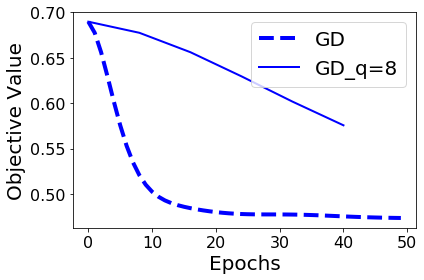

In [142]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(6, 4))

epochs_gd = range(len(objvals_gd))
epochs_gd_q8 = range(0, len(objvals_gd_q8)*local_iters, local_iters)


line0, = plt.plot(epochs_gd, objvals_gd, '--b', LineWidth=4)
line1, = plt.plot(epochs_gd_q8, objvals_gd_q8, '-b', LineWidth=2)

# line2, = plt.plot(epochs_sgd, objvals_sgd, '--r', LineWidth=4)
# line3, = plt.plot(epochs_sgd_q8, objvals_sgd_q8, '-r', LineWidth=2)

plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=16)
plt.yticks(FontSize=16)
plt.legend([line0, line1], ['GD', 'GD_q=8', 'SGD', 'SGD_q=8'], fontsize=20)
plt.tight_layout()
plt.show()
fig.savefig('compare_gd_with_q8.pdf', format='pdf', dpi=1200)

# **Bonus 2 ends here**